In [ ]:
from google.colab import drive
drive.mount('/content/drive')
SAVE_FOLDER = '/content/drive/MyDrive/Projects/modal/pos_02_benchmark/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 3 axioms

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F  # Added for ECE
import nltk
from collections import defaultdict
import numpy as np
import warnings
from tqdm.notebook import tqdm
import time  # Added for performance timing
import os  # Added for saving models/plots
import matplotlib.pyplot as plt  # Added for plotting
import pandas as pd  # Added for plotting

# --- 1. SETUP AND DATA PREPARATION ---
print("Step 1: Setting up and preparing data...")
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)
corpus = nltk.corpus.brown.tagged_sents(tagset='universal')

word_to_ix = {"<PAD>": 0, "<UNK>": 1}; tag_to_ix = {"<PAD>": 0}
for sent in corpus:
    for word, tag in sent:
        if word not in word_to_ix: word_to_ix[word] = len(word_to_ix)
        if tag not in tag_to_ix: tag_to_ix[tag] = len(tag_to_ix)

vocab_size = len(word_to_ix); tagset_size = len(tag_to_ix)

# --- Add inverse mappings for printing examples ---
ix_to_word = {v: k for k, v in word_to_ix.items()}
ix_to_tag = {v: k for k, v in tag_to_ix.items()}


class POSDataset(Dataset):
    def __init__(self, corpus_subset, word_to_ix, tag_to_ix):
        self.sentences, self.tags = [], []
        for sent in corpus_subset:
            sent_ix = [word_to_ix.get(w, 1) for w, t in sent]
            tag_ix = [tag_to_ix[t] for w, t in sent]
            self.sentences.append(torch.tensor(sent_ix, dtype=torch.long))
            self.tags.append(torch.tensor(tag_ix, dtype=torch.long))
    def __len__(self): return len(self.sentences)
    def __getitem__(self, idx): return self.sentences[idx], self.tags[idx]

def collate_fn(batch):
    sents, tags = zip(*batch)
    sents_pad = nn.utils.rnn.pad_sequence(sents, batch_first=True, padding_value=0)
    tags_pad = nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=0)
    return sents_pad, tags_pad

subset_corpus = corpus[:]
train_size = int(0.8 * len(subset_corpus))
train_corpus, test_corpus = torch.utils.data.random_split(subset_corpus, [train_size, len(subset_corpus) - train_size])
train_dataset = POSDataset(list(train_corpus), word_to_ix, tag_to_ix)
test_dataset = POSDataset(list(test_corpus), word_to_ix, tag_to_ix)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)
print(f"Data ready. Vocab size: {vocab_size}, Tagset size: {tagset_size}")
print("-" * 50)

# --- 2. MODEL DEFINITIONS ---
print("Step 2: Defining the Baseline LSTM and Structurally-Aware MLNN...")

class BaselineLSTMTagger(nn.Module):
    def __init__(self, v_size, t_size, e_dim=64, h_dim=128):
        super(BaselineLSTMTagger, self).__init__()
        self.emb = nn.Embedding(v_size, e_dim, padding_idx=0)
        self.lstm = nn.LSTM(e_dim, h_dim, bidirectional=True, batch_first=True)
        self.h2t = nn.Linear(h_dim * 2, t_size)
    def forward(self, sentence):
        embeds = self.emb(sentence)
        lstm_out, _ = self.lstm(embeds)
        return self.h2t(lstm_out)

class FullMLNNTagger(nn.Module):
    def __init__(self, v_size, t_size, e_dim=64, h_dim=128):
        super(FullMLNNTagger, self).__init__()
        self.num_worlds = 3
        self.tag_to_ix = tag_to_ix
        self.proposer = BaselineLSTMTagger(v_size, t_size, e_dim, h_dim)
        self.accessibility_logits = nn.Parameter(torch.randn(self.num_worlds, self.num_worlds))

    def get_accessibility_matrix(self):
        return torch.sigmoid(self.accessibility_logits)

    # --- MODIFIED: Specialized World Creation (for 3 rules) ---
    def _create_pessimistic_world(self, logits, penalty=2.0):
        """Creates a world that actively penalizes logits that would violate necessity axioms."""
        pessimistic_logits = logits.clone()
        probs = torch.softmax(logits[:, :-1, :], dim=-1)
        ix = self.tag_to_ix

        # Penalize bad bigrams based on necessity axioms
        pessimistic_logits[:, 1:, ix['VERB']] -= probs[:, :, ix['DET']] * penalty  # DET -> VERB (Axiom 1)
        # (Axiom 3 is 3-token, harder to penalize here, this is consistent with original notebook)
        return pessimistic_logits

    def _create_exploratory_world(self, logits, noise_level=0.1):
        return logits + torch.randn_like(logits) * noise_level

    # --- Differentiable Operators ---
    def op_box(self, probs, A):
        probs_exp = probs.unsqueeze(2); A_exp = A.unsqueeze(0).unsqueeze(0)
        box_result = torch.min((1 - A_exp) + probs_exp, dim=3).values
        return torch.clamp(box_result, min=0, max=1)

    def op_diamond(self, probs, A):
        probs_exp = probs.unsqueeze(2); A_exp = A.unsqueeze(0).unsqueeze(0)
        diamond_result = torch.sum(A_exp * probs_exp, dim=3)
        return torch.clamp(diamond_result, min=0, max=1)

    def op_or(self, p1, p2): return torch.clamp(p1 + p2, min=0, max=1)
    def op_implies(self, p1, p2): return self.op_or(1 - p1, p2)
    def soft_min(self, t, dim, temp=0.1): return -temp * torch.logsumexp(-t / temp, dim=dim)

    # --- MODIFIED: Calculate losses for 3 Axioms ---
    def calculate_losses(self, sentence, tags):
        logits = self.proposer(sentence) # Get logits for supervised loss
        real_probs = torch.softmax(logits, dim=-1)
        pessimistic_probs = torch.softmax(self._create_pessimistic_world(logits), dim=-1)
        exploratory_probs = torch.softmax(self._create_exploratory_world(logits), dim=-1)

        all_world_probs = torch.stack([real_probs, pessimistic_probs, exploratory_probs], dim=2)
        A = self.get_accessibility_matrix()
        ix = self.tag_to_ix

        # --- Evaluate 3 Axioms ---
        # Axiom 1: □ ¬(DET_i ∧ VERB_{i+1})
        p1 = 1 - (all_world_probs[:, :-1, :, ix['DET']] * all_world_probs[:, 1:, :, ix['VERB']])
        loss1 = 1.0 - torch.mean(self.soft_min(self.op_box(p1, A)[:, :, 0], dim=1))

        # Axiom 2: ADJ_i -> ◇(NOUN_{i+1} ∨ ADJ_{i+1})
        p2_premise = all_world_probs[:, :-1, :, ix['ADJ']]; p2_conseq = self.op_or(all_world_probs[:, 1:, :, ix['NOUN']], all_world_probs[:, 1:, :, ix['ADJ']])
        loss2 = 1.0 - torch.mean(self.op_implies(p2_premise[:, :, 0], self.op_diamond(p2_conseq, A)[:, :, 0]))

        # Axiom 3: □ ¬(VERB_i ∧ CONJ_{i+1} ∧ ADJ_{i+2})
        p3 = 1 - (all_world_probs[:, :-2, :, ix['VERB']] * all_world_probs[:, 1:-1, :, ix['CONJ']] * all_world_probs[:, 2:, :, ix['ADJ']])
        loss3 = 1.0 - torch.mean(self.soft_min(self.op_box(p3, A)[:, :, 0], dim=1))

        # --- Sum only 3 losses ---
        contradiction_loss = loss1 + loss2 + loss3

        supervised_loss = nn.CrossEntropyLoss(ignore_index=0)(logits.view(-1, tagset_size), tags.view(-1))

        return supervised_loss, contradiction_loss

    def forward(self, sentence):
        return self.proposer(sentence)

# --- 3. HELPER FUNCTIONS (ECE) ---

def calculate_ece(logits, labels, n_bins=15):
    """Calculates the Expected Calibration Error (ECE)"""
    # Move to CPU for calculations if they are on different devices
    logits, labels = logits.cpu(), labels.cpu()

    with torch.no_grad():
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        ece = torch.zeros(1) # On CPU
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        return ece.item() * 100 # Return as percentage

# --- 4. MODIFIED TRAINING AND EVALUATION LOOPS ---

def train_baseline(model, loader, optimizer, epochs=5, device="cpu"):
    print("\n--- Training Baseline LSTM Tagger ---")
    model.train()
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    epoch_times = []
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(0)

    for epoch in tqdm(range(epochs)):
        epoch_start_time = time.time()
        total_loss = 0

        for sents, tags in loader:
            sents = sents.to(device)
            tags = tags.to(device)

            optimizer.zero_grad()
            logits = model(sents)
            loss = loss_fn(logits.view(-1, tagset_size), tags.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)
        print(f"Epoch {epoch+1}/{epochs} | Supervised Loss: {total_loss / len(loader):.4f}")

    avg_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0
    print(f"Average time per epoch: {avg_time:.2f} seconds")

    peak_mem_gb = 0.0
    if torch.cuda.is_available():
        peak_mem_gb = torch.cuda.max_memory_allocated(0) / (1024**3)
        print(f"Peak GPU Memory usage: {peak_mem_gb:.2f} GB")

    return {"avg_time_per_epoch": avg_time, "peak_memory_gb": peak_mem_gb}

def train_full_mlnn(model, loader, optimizer, alpha, beta, epochs=5, device="cpu"):
    # --- MODIFIED: Printout for 3 Axioms ---
    print(f"\n--- Training Structurally-Aware MLNN (3 Axioms, Beta={beta}) ---")
    model.train()

    epoch_times = []
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(0)

    for epoch in tqdm(range(epochs)):
        epoch_start_time = time.time()
        sup_loss_total, con_loss_total = 0, 0

        for sents, tags in loader:
            sents = sents.to(device)
            tags = tags.to(device)

            optimizer.zero_grad()
            sup_loss, con_loss = model.calculate_losses(sents, tags)
            combined_loss = (alpha * sup_loss) + (beta * con_loss)
            combined_loss.backward()
            optimizer.step()
            sup_loss_total += sup_loss.item()
            con_loss_total += con_loss.item()

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)
        print(f"Epoch {epoch+1}/{epochs} | Supervised Loss: {sup_loss_total / len(loader):.4f} | Contradiction Loss: {con_loss_total / len(loader):.4f}")

    avg_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0
    print(f"Average time per epoch: {avg_time:.2f} seconds")

    peak_mem_gb = 0.0
    if torch.cuda.is_available():
        peak_mem_gb = torch.cuda.max_memory_allocated(0) / (1024**3)
        print(f"Peak GPU Memory usage: {peak_mem_gb:.2f} GB")

    return {"avg_time_per_epoch": avg_time, "peak_memory_gb": peak_mem_gb}

# --- MODIFIED: Evaluate function for 3 Axioms ---
def evaluate(model, loader, model_name, ix_to_word, ix_to_tag, device="cpu"):
    print(f"\nEvaluating {model_name}...")
    model.eval()
    correct, total = 0, 0

    all_logits = []
    all_labels = []

    errors = defaultdict(lambda: {'count': 0, 'examples': []})

    ix = tag_to_ix
    total_tokens = 0

    with torch.no_grad():
        for sents, tags in loader:
            sents = sents.to(device)
            tags = tags.to(device)

            outputs = model(sents)
            _, predicted = torch.max(outputs, 2)

            mask = (tags != 0)
            total_tokens += mask.sum().item()

            correct += (predicted[mask] == tags[mask]).sum().item()
            total += mask.sum().item()

            all_logits.append(outputs[mask])
            all_labels.append(tags[mask])

            sents_cpu = sents.cpu()
            predicted_cpu = predicted.cpu()
            mask_cpu = mask.cpu()

            for i in range(predicted_cpu.shape[0]):
                sent_words = [ix_to_word.get(idx.item(), '<UNK>') for idx in sents_cpu[i] if idx.item() != 0]

                for j in range(predicted_cpu.shape[1] - 1):
                    if not (mask_cpu[i, j] and mask_cpu[i, j+1]): continue

                    def get_example(idx, window=5):
                        start = max(0, idx - window)
                        end = min(len(sent_words), idx + window + 2)
                        words_with_tags = []
                        for k in range(start, end):
                            if k >= len(sent_words): break
                            tag = ix_to_tag[predicted_cpu[i, k].item()]
                            word = sent_words[k]
                            if k == idx or k == idx+1 or (error_type == 'VERB -> CONJ -> ADJ' and k == idx+2):
                                words_with_tags.append(f"**{word}/{tag}**")
                            else:
                                words_with_tags.append(f"{word}/{tag}")
                        return " ".join(words_with_tags)

                    error_type = None
                    pred_j = predicted_cpu[i, j].item()
                    pred_j1 = predicted_cpu[i, j+1].item()

                    # --- Only check for 3 axiom errors ---
                    if pred_j == ix['DET'] and pred_j1 == ix['VERB']: error_type = 'DET -> VERB'
                    elif pred_j == ix['ADJ'] and not (pred_j1 == ix['NOUN'] or pred_j1 == ix['ADJ']): error_type = 'ADJ -> Other'

                    if j < predicted_cpu.shape[1] - 2 and mask_cpu[i, j+2]:
                        pred_j2 = predicted_cpu[i, j+2].item()
                        if (pred_j == ix['VERB'] and pred_j1 == ix['CONJ'] and pred_j2 == ix['ADJ']):
                            error_type = 'VERB -> CONJ -> ADJ'
                    # --- End of error checking block ---

                    if error_type:
                        errors[error_type]['count'] += 1
                        if len(errors[error_type]['examples']) < 3:
                            errors[error_type]['examples'].append(get_example(j))

    accuracy = 100 * correct / total
    ece = calculate_ece(torch.cat(all_logits), torch.cat(all_labels))
    total_errors = sum(v['count'] for v in errors.values())
    errors_per_10k = (total_errors / total_tokens) * 10000

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "ece": ece,
        "total_errors": total_errors,
        "errors_per_10k": errors_per_10k,
        "errors_breakdown": errors,
    }

# --- 5. MODIFIED MAIN EXECUTION ---
if __name__ == "__main__":
    # --- 1. DEFINE DEVICE ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    E_DIM, H_DIM, EPOCHS = 64, 128 , 32
    ALPHA, BETA = 0.1, 0.0 # Using Beta=0.9
    print(f'USING SAVE_FOLDER {SAVE_FOLDER}')
    # SAVE_FOLDER = '/content/drive/MyDrive/Projects/modal/pos/'
    if not os.path.exists(SAVE_FOLDER):
        os.makedirs(SAVE_FOLDER)
        print(f"Created save folder: {SAVE_FOLDER}")

    # --- 2. Train Baseline ---
    print("\n" + "="*80)
    print("           RUNNING BASELINE EXPERIMENT")
    print("="*80)
    baseline_model = BaselineLSTMTagger(vocab_size, tagset_size, E_DIM, H_DIM)
    baseline_model.to(device)
    optimizer_base = optim.Adam(baseline_model.parameters(), lr=0.001)

    baseline_path = os.path.join(SAVE_FOLDER, 'baseline_lstm_tagger.pth')
    if os.path.exists(baseline_path):
        baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))
        print("Loaded pre-trained baseline model.")
        baseline_train_stats = {"avg_time_per_epoch": "N/A (Loaded)", "peak_memory_gb": "N/A (Loaded)"}
    else:
        print("Training baseline model...")
        baseline_train_stats = train_baseline(baseline_model, train_loader, optimizer_base, epochs=EPOCHS, device=device)
        torch.save(baseline_model.state_dict(), baseline_path)
        print(f"Baseline model saved to {baseline_path}")

    # --- 3. Train MLNN ---
    print("\n" + "="*80)
    # --- MODIFIED: Printout for 3 Axioms ---
    print(f"          RUNNING MLNN EXPERIMENT (3 AXIOMS, BETA={BETA})")
    print("="*80)
    mlnn_model = FullMLNNTagger(vocab_size, tagset_size, E_DIM, H_DIM)
    mlnn_model.to(device)
    optimizer_mlnn = optim.Adam(mlnn_model.parameters(), lr=0.001)

    mlnn_train_stats = train_full_mlnn(mlnn_model, train_loader, optimizer_mlnn, ALPHA, BETA, epochs=EPOCHS, device=device)

    # --- MODIFIED: Save path for 3 Axioms ---
    mlnn_path = os.path.join(SAVE_FOLDER, f'mlnn_tagger_3_axioms_beta_{BETA}.pth')
    torch.save(mlnn_model.state_dict(), mlnn_path)
    print(f"MLNN model saved to {mlnn_path}")

    # --- 4. Evaluate Both Models ---
    baseline_results = evaluate(baseline_model, test_loader, "Baseline LSTM", ix_to_word, ix_to_tag, device=device)
    mlnn_results = evaluate(mlnn_model, test_loader, f"Full MLNN Tagger (3 Axioms, Beta={BETA})", ix_to_word, ix_to_tag, device=device)

    # --- 5. Print Full Comparison ---
    print("\n" + "="*80)
    # --- MODIFIED: Title for 3 Axioms ---
    print("            PERFORMANCE ANALYSIS: BASELINE vs. MLNN (3 Axioms)")
    print("="*80)

    # --- Baseline Results ---
    print("\n1. Baseline LSTM Tagger")
    print("-------------------------")
    print(f"  -> Accuracy:         {baseline_results['accuracy']:.2f}%")
    print(f"  -> ECE:              {baseline_results['ece']:.2f}%")
    print(f"  -> Errors / 10k:     {baseline_results['errors_per_10k']:.2f}")
    print(f"  -> Total Errors:     {baseline_results['total_errors']}")
    print(f"  -> Avg. Train Time:  {baseline_train_stats['avg_time_per_epoch']}")
    print(f"  -> Peak GPU Memory:  {baseline_train_stats['peak_memory_gb']}")
    print("\n  -> Grammatical Errors Committed (Baseline):")
    for error_type, data in sorted(baseline_results['errors_breakdown'].items()):
        print(f"     - {error_type:<20}: {data['count']}")

    # --- MLNN Results ---
    print("\n2. Structurally-Aware MLNN (with Specialized Worlds)")
    print("-----------------------------------------------------")
    print(f"  -> Accuracy:         {mlnn_results['accuracy']:.2f}%")
    print(f"  -> ECE:              {mlnn_results['ece']:.2f}%")
    print(f"  -> Errors / 10k:     {mlnn_results['errors_per_10k']:.2f}")
    print(f"  -> Total Errors:     {mlnn_results['total_errors']}")
    print(f"  -> Avg. Train Time:  {mlnn_train_stats['avg_time_per_epoch']:.2f} sec/epoch")
    print(f"  -> Peak GPU Memory:  {mlnn_train_stats['peak_memory_gb']:.2f} GB")
    print("\n  -> Grammatical Errors Committed (MLNN):")
    for error_type, data in sorted(mlnn_results['errors_breakdown'].items()):
        print(f"     - {error_type:<20}: {data['count']}")

    # --- Conclusion ---
    print("\n" + "="*80)
    print("CONCLUSION:")
    baseline_err_10k = baseline_results['errors_per_10k']
    mlnn_err_10k = mlnn_results['errors_per_10k']

    if mlnn_err_10k < baseline_err_10k and baseline_err_10k > 0:
        reduction_pct = (baseline_err_10k - mlnn_err_10k) / baseline_err_10k * 100
        print(f"✅ Success! The MLNN guardrail reduced grammatical errors by {reduction_pct:.1f}%.")
        print(f"   (Baseline Errors: {baseline_err_10k:.2f}/10k vs. MLNN Errors: {mlnn_err_10k:.2f}/10k)")
    else:
        print("🟡 The MLNN did not reduce errors compared to the baseline.")
        print(f"   (Baseline Errors: {baseline_err_10k:.2f}/10k vs. MLNN Errors: {mlnn_err_10k:.2f}/10k)")

    # --- 6. Misclassified Examples ---
    print("\n" + "="*80)
    print("           EXAMPLE ERROR ANALYSIS")
    print("="*80)

    all_error_types = set(baseline_results['errors_breakdown'].keys()) | set(mlnn_results['errors_breakdown'].keys())

    for error_type in sorted(list(all_error_types)):
        print(f"\n--- Error Type: [{error_type}] ---")

        print("\n  Baseline Examples:")
        if error_type in baseline_results['errors_breakdown']:
            examples = baseline_results['errors_breakdown'][error_type]['examples']
            if examples:
                for ex in examples:
                    print(f"    ... {ex} ...")
            else:
                print("    (No examples captured)")
        else:
            print(f"    (0 errors)")

        print(f"\n  MLNN (Beta={BETA}) Examples:")
        if error_type in mlnn_results['errors_breakdown']:
            examples = mlnn_results['errors_breakdown'][error_type]['examples']
            if examples:
                for ex in examples:
                    print(f"    ... {ex} ...")
            else:
                print("    (No examples captured)")
        else:
            print(f"    (0 errors)")

    print("\n" + "="*80)
    print("           PLOTTING (Requires Beta Sweep)")
    print("="*80)
    print("To generate Figures 2 and 3, you must run this script")
    print(f"for all beta values in the sweep: [0.0, 0.1, 0.3, 1.0]")
    print(f"This run only completed for Beta = {BETA}")

# 6 axioms

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F  # Added for ECE
import nltk
from collections import defaultdict
import numpy as np
import warnings
from tqdm.notebook import tqdm
import time  # Added for performance timing
import os  # Added for saving models/plots
import matplotlib.pyplot as plt  # Added for plotting
import pandas as pd  # Added for plotting

# --- 1. SETUP AND DATA PREPARATION ---
print("Step 1: Setting up and preparing data...")
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)
corpus = nltk.corpus.brown.tagged_sents(tagset='universal')

word_to_ix = {"<PAD>": 0, "<UNK>": 1}; tag_to_ix = {"<PAD>": 0}
for sent in corpus:
    for word, tag in sent:
        if word not in word_to_ix: word_to_ix[word] = len(word_to_ix)
        if tag not in tag_to_ix: tag_to_ix[tag] = len(tag_to_ix)

vocab_size = len(word_to_ix); tagset_size = len(tag_to_ix)

# --- Add inverse mappings for printing examples ---
ix_to_word = {v: k for k, v in word_to_ix.items()}
ix_to_tag = {v: k for k, v in tag_to_ix.items()}


class POSDataset(Dataset):
    def __init__(self, corpus_subset, word_to_ix, tag_to_ix):
        self.sentences, self.tags = [], []
        for sent in corpus_subset:
            sent_ix = [word_to_ix.get(w, 1) for w, t in sent]
            tag_ix = [tag_to_ix[t] for w, t in sent]
            self.sentences.append(torch.tensor(sent_ix, dtype=torch.long))
            self.tags.append(torch.tensor(tag_ix, dtype=torch.long))
    def __len__(self): return len(self.sentences)
    def __getitem__(self, idx): return self.sentences[idx], self.tags[idx]

def collate_fn(batch):
    sents, tags = zip(*batch)
    sents_pad = nn.utils.rnn.pad_sequence(sents, batch_first=True, padding_value=0)
    tags_pad = nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=0)
    return sents_pad, tags_pad

subset_corpus = corpus[:]
train_size = int(0.8 * len(subset_corpus))
train_corpus, test_corpus = torch.utils.data.random_split(subset_corpus, [train_size, len(subset_corpus) - train_size])
train_dataset = POSDataset(list(train_corpus), word_to_ix, tag_to_ix)
test_dataset = POSDataset(list(test_corpus), word_to_ix, tag_to_ix)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)
print(f"Data ready. Vocab size: {vocab_size}, Tagset size: {tagset_size}")
print("-" * 50)

# --- 2. MODEL DEFINITIONS ---
print("Step 2: Defining the Baseline LSTM and Structurally-Aware MLNN...")

class BaselineLSTMTagger(nn.Module):
    def __init__(self, v_size, t_size, e_dim=64, h_dim=128):
        super(BaselineLSTMTagger, self).__init__()
        self.emb = nn.Embedding(v_size, e_dim, padding_idx=0)
        self.lstm = nn.LSTM(e_dim, h_dim, bidirectional=True, batch_first=True)
        self.h2t = nn.Linear(h_dim * 2, t_size)
    def forward(self, sentence):
        embeds = self.emb(sentence)
        lstm_out, _ = self.lstm(embeds)
        return self.h2t(lstm_out)

class FullMLNNTagger(nn.Module):
    def __init__(self, v_size, t_size, e_dim=64, h_dim=128):
        super(FullMLNNTagger, self).__init__()
        self.num_worlds = 3
        self.tag_to_ix = tag_to_ix
        self.proposer = BaselineLSTMTagger(v_size, t_size, e_dim, h_dim)
        self.accessibility_logits = nn.Parameter(torch.randn(self.num_worlds, self.num_worlds))

    def get_accessibility_matrix(self):
        return torch.sigmoid(self.accessibility_logits)

    # --- MODIFIED: Specialized World Creation (for 6 rules) ---
    def _create_pessimistic_world(self, logits, penalty=2.0):
        """Creates a world that actively penalizes logits that would violate necessity axioms."""
        pessimistic_logits = logits.clone()
        probs = torch.softmax(logits[:, :-1, :], dim=-1)
        ix = self.tag_to_ix

        # Penalize bad bigrams based on necessity axioms
        pessimistic_logits[:, 1:, ix['VERB']] -= probs[:, :, ix['DET']] * penalty  # DET -> VERB (Axiom 1)
        pessimistic_logits[:, 1:, ix['VERB']] -= probs[:, :, ix['ADP']] * penalty  # ADP -> VERB (Axiom 4)
        pessimistic_logits[:, 1:, ix['DET']]  -= probs[:, :, ix['PRON']] * penalty # PRON -> DET (Axiom 5)
        return pessimistic_logits

    def _create_exploratory_world(self, logits, noise_level=0.1):
        return logits + torch.randn_like(logits) * noise_level

    # --- Differentiable Operators ---
    def op_box(self, probs, A):
        probs_exp = probs.unsqueeze(2); A_exp = A.unsqueeze(0).unsqueeze(0)
        box_result = torch.min((1 - A_exp) + probs_exp, dim=3).values
        return torch.clamp(box_result, min=0, max=1)

    def op_diamond(self, probs, A):
        probs_exp = probs.unsqueeze(2); A_exp = A.unsqueeze(0).unsqueeze(0)
        diamond_result = torch.sum(A_exp * probs_exp, dim=3)
        return torch.clamp(diamond_result, min=0, max=1)

    def op_or(self, p1, p2): return torch.clamp(p1 + p2, min=0, max=1)
    def op_implies(self, p1, p2): return self.op_or(1 - p1, p2)
    def soft_min(self, t, dim, temp=0.1): return -temp * torch.logsumexp(-t / temp, dim=dim)

    # --- MODIFIED: Calculate losses for 6 Axioms ---
    def calculate_losses(self, sentence, tags):
        logits = self.proposer(sentence) # Get logits for supervised loss
        real_probs = torch.softmax(logits, dim=-1)
        pessimistic_probs = torch.softmax(self._create_pessimistic_world(logits), dim=-1)
        exploratory_probs = torch.softmax(self._create_exploratory_world(logits), dim=-1)

        all_world_probs = torch.stack([real_probs, pessimistic_probs, exploratory_probs], dim=2)
        A = self.get_accessibility_matrix()
        ix = self.tag_to_ix

        # --- Evaluate 6 Axioms ---
        # Axiom 1: □ ¬(DET_i ∧ VERB_{i+1})
        p1 = 1 - (all_world_probs[:, :-1, :, ix['DET']] * all_world_probs[:, 1:, :, ix['VERB']])
        loss1 = 1.0 - torch.mean(self.soft_min(self.op_box(p1, A)[:, :, 0], dim=1))

        # Axiom 2: ADJ_i -> ◇(NOUN_{i+1} ∨ ADJ_{i+1})
        p2_premise = all_world_probs[:, :-1, :, ix['ADJ']]; p2_conseq = self.op_or(all_world_probs[:, 1:, :, ix['NOUN']], all_world_probs[:, 1:, :, ix['ADJ']])
        loss2 = 1.0 - torch.mean(self.op_implies(p2_premise[:, :, 0], self.op_diamond(p2_conseq, A)[:, :, 0]))

        # Axiom 3: □ ¬(VERB_i ∧ CONJ_{i+1} ∧ ADJ_{i+2})
        p3 = 1 - (all_world_probs[:, :-2, :, ix['VERB']] * all_world_probs[:, 1:-1, :, ix['CONJ']] * all_world_probs[:, 2:, :, ix['ADJ']])
        loss3 = 1.0 - torch.mean(self.soft_min(self.op_box(p3, A)[:, :, 0], dim=1))

        # Axiom 4: □ ¬(ADP_i ∧ VERB_{i+1})
        p4 = 1 - (all_world_probs[:, :-1, :, ix['ADP']] * all_world_probs[:, 1:, :, ix['VERB']])
        loss4 = 1.0 - torch.mean(self.soft_min(self.op_box(p4, A)[:, :, 0], dim=1))

        # Axiom 5: □ ¬(PRON_i ∧ DET_{i+1})
        p5 = 1 - (all_world_probs[:, :-1, :, ix['PRON']] * all_world_probs[:, 1:, :, ix['DET']])
        loss5 = 1.0 - torch.mean(self.soft_min(self.op_box(p5, A)[:, :, 0], dim=1))

        # Axiom 6: PRON_i -> ◇(VERB_{i+1})
        p6_premise = all_world_probs[:, :-1, :, ix['PRON']]; p6_conseq = all_world_probs[:, 1:, :, ix['VERB']]
        loss6 = 1.0 - torch.mean(self.op_implies(p6_premise[:, :, 0], self.op_diamond(p6_conseq, A)[:, :, 0]))

        # --- Sum only 6 losses ---
        contradiction_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6

        supervised_loss = nn.CrossEntropyLoss(ignore_index=0)(logits.view(-1, tagset_size), tags.view(-1))

        return supervised_loss, contradiction_loss

    def forward(self, sentence):
        return self.proposer(sentence)

# --- 3. HELPER FUNCTIONS (ECE) ---

def calculate_ece(logits, labels, n_bins=15):
    """Calculates the Expected Calibration Error (ECE)"""
    # Move to CPU for calculations if they are on different devices
    logits, labels = logits.cpu(), labels.cpu()

    with torch.no_grad():
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        ece = torch.zeros(1) # On CPU
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        return ece.item() * 100 # Return as percentage

# --- 4. MODIFIED TRAINING AND EVALUATION LOOPS ---

def train_baseline(model, loader, optimizer, epochs=5, device="cpu"):
    print("\n--- Training Baseline LSTM Tagger ---")
    model.train()
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    epoch_times = []
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(0)

    for epoch in tqdm(range(epochs)):
        epoch_start_time = time.time()
        total_loss = 0

        for sents, tags in loader:
            sents = sents.to(device)
            tags = tags.to(device)

            optimizer.zero_grad()
            logits = model(sents)
            loss = loss_fn(logits.view(-1, tagset_size), tags.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)
        print(f"Epoch {epoch+1}/{epochs} | Supervised Loss: {total_loss / len(loader):.4f}")

    avg_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0
    print(f"Average time per epoch: {avg_time:.2f} seconds")

    peak_mem_gb = 0.0
    if torch.cuda.is_available():
        peak_mem_gb = torch.cuda.max_memory_allocated(0) / (1024**3)
        print(f"Peak GPU Memory usage: {peak_mem_gb:.2f} GB")

    return {"avg_time_per_epoch": avg_time, "peak_memory_gb": peak_mem_gb}

def train_full_mlnn(model, loader, optimizer, alpha, beta, epochs=5, device="cpu"):
    # --- MODIFIED: Printout for 6 Axioms ---
    print(f"\n--- Training Structurally-Aware MLNN (6 Axioms, Beta={beta}) ---")
    model.train()

    epoch_times = []
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(0)

    for epoch in tqdm(range(epochs)):
        epoch_start_time = time.time()
        sup_loss_total, con_loss_total = 0, 0

        for sents, tags in loader:
            sents = sents.to(device)
            tags = tags.to(device)

            optimizer.zero_grad()
            sup_loss, con_loss = model.calculate_losses(sents, tags)
            combined_loss = (alpha * sup_loss) + (beta * con_loss)
            combined_loss.backward()
            optimizer.step()
            sup_loss_total += sup_loss.item()
            con_loss_total += con_loss.item()

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)
        print(f"Epoch {epoch+1}/{epochs} | Supervised Loss: {sup_loss_total / len(loader):.4f} | Contradiction Loss: {con_loss_total / len(loader):.4f}")

    avg_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0
    print(f"Average time per epoch: {avg_time:.2f} seconds")

    peak_mem_gb = 0.0
    if torch.cuda.is_available():
        peak_mem_gb = torch.cuda.max_memory_allocated(0) / (1024**3)
        print(f"Peak GPU Memory usage: {peak_mem_gb:.2f} GB")

    return {"avg_time_per_epoch": avg_time, "peak_memory_gb": peak_mem_gb}

# --- MODIFIED: Evaluate function for 6 Axioms ---
def evaluate(model, loader, model_name, ix_to_word, ix_to_tag, device="cpu"):
    print(f"\nEvaluating {model_name}...")
    model.eval()
    correct, total = 0, 0

    all_logits = []
    all_labels = []

    errors = defaultdict(lambda: {'count': 0, 'examples': []})

    ix = tag_to_ix
    total_tokens = 0

    with torch.no_grad():
        for sents, tags in loader:
            sents = sents.to(device)
            tags = tags.to(device)

            outputs = model(sents)
            _, predicted = torch.max(outputs, 2)

            mask = (tags != 0)
            total_tokens += mask.sum().item()

            correct += (predicted[mask] == tags[mask]).sum().item()
            total += mask.sum().item()

            all_logits.append(outputs[mask])
            all_labels.append(tags[mask])

            sents_cpu = sents.cpu()
            predicted_cpu = predicted.cpu()
            mask_cpu = mask.cpu()

            for i in range(predicted_cpu.shape[0]):
                sent_words = [ix_to_word.get(idx.item(), '<UNK>') for idx in sents_cpu[i] if idx.item() != 0]

                for j in range(predicted_cpu.shape[1] - 1):
                    if not (mask_cpu[i, j] and mask_cpu[i, j+1]): continue

                    def get_example(idx, window=5):
                        start = max(0, idx - window)
                        end = min(len(sent_words), idx + window + 2)
                        words_with_tags = []
                        for k in range(start, end):
                            if k >= len(sent_words): break
                            tag = ix_to_tag[predicted_cpu[i, k].item()]
                            word = sent_words[k]
                            if k == idx or k == idx+1 or (error_type == 'VERB -> CONJ -> ADJ' and k == idx+2):
                                words_with_tags.append(f"**{word}/{tag}**")
                            else:
                                words_with_tags.append(f"{word}/{tag}")
                        return " ".join(words_with_tags)

                    error_type = None
                    pred_j = predicted_cpu[i, j].item()
                    pred_j1 = predicted_cpu[i, j+1].item()

                    # --- Only check for 6 axiom errors ---
                    if pred_j == ix['DET'] and pred_j1 == ix['VERB']: error_type = 'DET -> VERB'
                    elif pred_j == ix['ADJ'] and not (pred_j1 == ix['NOUN'] or pred_j1 == ix['ADJ']): error_type = 'ADJ -> Other'
                    elif pred_j == ix['ADP'] and pred_j1 == ix['VERB']: error_type = 'ADP -> VERB'
                    elif pred_j == ix['PRON'] and pred_j1 == ix['DET']: error_type = 'PRON -> DET'
                    elif pred_j == ix['PRON'] and not (pred_j1 == ix['VERB']): error_type = 'PRON -> not VERB'

                    if j < predicted_cpu.shape[1] - 2 and mask_cpu[i, j+2]:
                        pred_j2 = predicted_cpu[i, j+2].item()
                        if (pred_j == ix['VERB'] and pred_j1 == ix['CONJ'] and pred_j2 == ix['ADJ']):
                            error_type = 'VERB -> CONJ -> ADJ'
                    # --- End of error checking block ---

                    if error_type:
                        errors[error_type]['count'] += 1
                        if len(errors[error_type]['examples']) < 3:
                            errors[error_type]['examples'].append(get_example(j))

    accuracy = 100 * correct / total
    ece = calculate_ece(torch.cat(all_logits), torch.cat(all_labels))
    total_errors = sum(v['count'] for v in errors.values())
    errors_per_10k = (total_errors / total_tokens) * 10000

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "ece": ece,
        "total_errors": total_errors,
        "errors_per_10k": errors_per_10k,
        "errors_breakdown": errors,
    }

# --- 5. MODIFIED MAIN EXECUTION ---
if __name__ == "__main__":
    # --- 1. DEFINE DEVICE ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    E_DIM, H_DIM, EPOCHS = 64, 128 , 32
    ALPHA, BETA = 0.1, 0.0 # Using Beta=0.9
    if not os.path.exists(SAVE_FOLDER):
        os.makedirs(SAVE_FOLDER)
        print(f"Created save folder: {SAVE_FOLDER}")

    # --- 2. Train Baseline ---
    print("\n" + "="*80)
    print("           RUNNING BASELINE EXPERIMENT")
    print("="*80)
    baseline_model = BaselineLSTMTagger(vocab_size, tagset_size, E_DIM, H_DIM)
    baseline_model.to(device)
    optimizer_base = optim.Adam(baseline_model.parameters(), lr=0.001)

    baseline_path = os.path.join(SAVE_FOLDER, 'baseline_lstm_tagger.pth')
    if os.path.exists(baseline_path):
        baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))
        print("Loaded pre-trained baseline model.")
        baseline_train_stats = {"avg_time_per_epoch": "N/A (Loaded)", "peak_memory_gb": "N/A (Loaded)"}
    else:
        print("Training baseline model...")
        baseline_train_stats = train_baseline(baseline_model, train_loader, optimizer_base, epochs=EPOCHS, device=device)
        torch.save(baseline_model.state_dict(), baseline_path)
        print(f"Baseline model saved to {baseline_path}")

    # --- 3. Train MLNN ---
    print("\n" + "="*80)
    # --- MODIFIED: Printout for 6 Axioms ---
    print(f"          RUNNING MLNN EXPERIMENT (6 AXIOMS, BETA={BETA})")
    print("="*80)
    mlnn_model = FullMLNNTagger(vocab_size, tagset_size, E_DIM, H_DIM)
    mlnn_model.to(device)
    optimizer_mlnn = optim.Adam(mlnn_model.parameters(), lr=0.001)

    mlnn_train_stats = train_full_mlnn(mlnn_model, train_loader, optimizer_mlnn, ALPHA, BETA, epochs=EPOCHS, device=device)

    # --- MODIFIED: Save path for 6 Axioms ---
    mlnn_path = os.path.join(SAVE_FOLDER, f'mlnn_tagger_6_axioms_beta_{BETA}.pth')
    torch.save(mlnn_model.state_dict(), mlnn_path)
    print(f"MLNN model saved to {mlnn_path}")

    # --- 4. Evaluate Both Models ---
    baseline_results = evaluate(baseline_model, test_loader, "Baseline LSTM", ix_to_word, ix_to_tag, device=device)
    mlnn_results = evaluate(mlnn_model, test_loader, f"Full MLNN Tagger (6 Axioms, Beta={BETA})", ix_to_word, ix_to_tag, device=device)

    # --- 5. Print Full Comparison ---
    print("\n" + "="*80)
    # --- MODIFIED: Title for 6 Axioms ---
    print("            PERFORMANCE ANALYSIS: BASELINE vs. MLNN (6 Axioms)")
    print("="*80)

    # --- Baseline Results ---
    print("\n1. Baseline LSTM Tagger")
    print("-------------------------")
    print(f"  -> Accuracy:         {baseline_results['accuracy']:.2f}%")
    print(f"  -> ECE:              {baseline_results['ece']:.2f}%")
    print(f"  -> Errors / 10k:     {baseline_results['errors_per_10k']:.2f}")
    print(f"  -> Total Errors:     {baseline_results['total_errors']}")
    print(f"  -> Avg. Train Time:  {baseline_train_stats['avg_time_per_epoch']}")
    print(f"  -> Peak GPU Memory:  {baseline_train_stats['peak_memory_gb']}")
    print("\n  -> Grammatical Errors Committed (Baseline):")
    for error_type, data in sorted(baseline_results['errors_breakdown'].items()):
        print(f"     - {error_type:<20}: {data['count']}")

    # --- MLNN Results ---
    print("\n2. Structurally-Aware MLNN (with Specialized Worlds)")
    print("-----------------------------------------------------")
    print(f"  -> Accuracy:         {mlnn_results['accuracy']:.2f}%")
    print(f"  -> ECE:              {mlnn_results['ece']:.2f}%")
    print(f"  -> Errors / 10k:     {mlnn_results['errors_per_10k']:.2f}")
    print(f"  -> Total Errors:     {mlnn_results['total_errors']}")
    print(f"  -> Avg. Train Time:  {mlnn_train_stats['avg_time_per_epoch']:.2f} sec/epoch")
    print(f"  -> Peak GPU Memory:  {mlnn_train_stats['peak_memory_gb']:.2f} GB")
    print("\n  -> Grammatical Errors Committed (MLNN):")
    for error_type, data in sorted(mlnn_results['errors_breakdown'].items()):
        print(f"     - {error_type:<20}: {data['count']}")

    # --- Conclusion ---
    print("\n" + "="*80)
    print("CONCLUSION:")
    baseline_err_10k = baseline_results['errors_per_10k']
    mlnn_err_10k = mlnn_results['errors_per_10k']

    if mlnn_err_10k < baseline_err_10k and baseline_err_10k > 0:
        reduction_pct = (baseline_err_10k - mlnn_err_10k) / baseline_err_10k * 100
        print(f"✅ Success! The MLNN guardrail reduced grammatical errors by {reduction_pct:.1f}%.")
        print(f"   (Baseline Errors: {baseline_err_10k:.2f}/10k vs. MLNN Errors: {mlnn_err_10k:.2f}/10k)")
    else:
        print("🟡 The MLNN did not reduce errors compared to the baseline.")
        print(f"   (Baseline Errors: {baseline_err_10k:.2f}/10k vs. MLNN Errors: {mlnn_err_10k:.2f}/10k)")

    # --- 6. Misclassified Examples ---
    print("\n" + "="*80)
    print("           EXAMPLE ERROR ANALYSIS")
    print("="*80)

    all_error_types = set(baseline_results['errors_breakdown'].keys()) | set(mlnn_results['errors_breakdown'].keys())

    for error_type in sorted(list(all_error_types)):
        print(f"\n--- Error Type: [{error_type}] ---")

        print("\n  Baseline Examples:")
        if error_type in baseline_results['errors_breakdown']:
            examples = baseline_results['errors_breakdown'][error_type]['examples']
            if examples:
                for ex in examples:
                    print(f"    ... {ex} ...")
            else:
                print("    (No examples captured)")
        else:
            print(f"    (0 errors)")

        print(f"\n  MLNN (Beta={BETA}) Examples:")
        if error_type in mlnn_results['errors_breakdown']:
            examples = mlnn_results['errors_breakdown'][error_type]['examples']
            if examples:
                for ex in examples:
                    print(f"    ... {ex} ...")
            else:
                print("    (No examples captured)")
        else:
            print(f"    (0 errors)")

    print("\n" + "="*80)
    print("           PLOTTING (Requires Beta Sweep)")
    print("="*80)
    print("To generate Figures 2 and 3, you must run this script")
    print(f"for all beta values in the sweep: [0.0, 0.1, 0.3, 1.0]")
    print(f"This run only completed for Beta = {BETA}")

# 10 axioms

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F  # Added for ECE
import nltk
from collections import defaultdict
import numpy as np
import warnings
from tqdm.notebook import tqdm
import time  # Added for performance timing
import os  # Added for saving models/plots
import matplotlib.pyplot as plt  # Added for plotting
import pandas as pd  # Added for plotting

# --- 1. SETUP AND DATA PREPARATION ---
print("Step 1: Setting up and preparing data...")
nltk.download('brown', quiet=True)
nltk.download('universal_tagset', quiet=True)
corpus = nltk.corpus.brown.tagged_sents(tagset='universal')

word_to_ix = {"<PAD>": 0, "<UNK>": 1}; tag_to_ix = {"<PAD>": 0}
for sent in corpus:
    for word, tag in sent:
        if word not in word_to_ix: word_to_ix[word] = len(word_to_ix)
        if tag not in tag_to_ix: tag_to_ix[tag] = len(tag_to_ix)

vocab_size = len(word_to_ix); tagset_size = len(tag_to_ix)

# --- Add inverse mappings for printing examples ---
ix_to_word = {v: k for k, v in word_to_ix.items()}
ix_to_tag = {v: k for k, v in tag_to_ix.items()}


class POSDataset(Dataset):
    def __init__(self, corpus_subset, word_to_ix, tag_to_ix):
        self.sentences, self.tags = [], []
        for sent in corpus_subset:
            sent_ix = [word_to_ix.get(w, 1) for w, t in sent]
            tag_ix = [tag_to_ix[t] for w, t in sent]
            self.sentences.append(torch.tensor(sent_ix, dtype=torch.long))
            self.tags.append(torch.tensor(tag_ix, dtype=torch.long))
    def __len__(self): return len(self.sentences)
    def __getitem__(self, idx): return self.sentences[idx], self.tags[idx]

def collate_fn(batch):
    sents, tags = zip(*batch)
    sents_pad = nn.utils.rnn.pad_sequence(sents, batch_first=True, padding_value=0)
    tags_pad = nn.utils.rnn.pad_sequence(tags, batch_first=True, padding_value=0)
    return sents_pad, tags_pad

subset_corpus = corpus[:]
train_size = int(0.8 * len(subset_corpus))
train_corpus, test_corpus = torch.utils.data.random_split(subset_corpus, [train_size, len(subset_corpus) - train_size])
train_dataset = POSDataset(list(train_corpus), word_to_ix, tag_to_ix)
test_dataset = POSDataset(list(test_corpus), word_to_ix, tag_to_ix)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)
print(f"Data ready. Vocab size: {vocab_size}, Tagset size: {tagset_size}")
print("-" * 50)

# --- 2. MODEL DEFINITIONS ---
print("Step 2: Defining the Baseline LSTM and Structurally-Aware MLNN...")

class BaselineLSTMTagger(nn.Module):
    def __init__(self, v_size, t_size, e_dim=64, h_dim=128):
        super(BaselineLSTMTagger, self).__init__()
        self.emb = nn.Embedding(v_size, e_dim, padding_idx=0)
        self.lstm = nn.LSTM(e_dim, h_dim, bidirectional=True, batch_first=True)
        self.h2t = nn.Linear(h_dim * 2, t_size)
    def forward(self, sentence):
        embeds = self.emb(sentence)
        lstm_out, _ = self.lstm(embeds)
        return self.h2t(lstm_out)

class FullMLNNTagger(nn.Module):
    def __init__(self, v_size, t_size, e_dim=64, h_dim=128):
        super(FullMLNNTagger, self).__init__()
        self.num_worlds = 3
        self.tag_to_ix = tag_to_ix
        self.proposer = BaselineLSTMTagger(v_size, t_size, e_dim, h_dim)
        self.accessibility_logits = nn.Parameter(torch.randn(self.num_worlds, self.num_worlds))

    def get_accessibility_matrix(self):
        return torch.sigmoid(self.accessibility_logits)

    def _create_pessimistic_world(self, logits, penalty=2.0):
        pessimistic_logits = logits.clone()
        probs = torch.softmax(logits[:, :-1, :], dim=-1)
        ix = self.tag_to_ix
        pessimistic_logits[:, 1:, ix['VERB']] -= probs[:, :, ix['DET']] * penalty
        pessimistic_logits[:, 1:, ix['VERB']] -= probs[:, :, ix['ADP']] * penalty
        pessimistic_logits[:, 1:, ix['DET']]  -= probs[:, :, ix['PRON']] * penalty
        pessimistic_logits[:, 1:, ix['NOUN']] -= probs[:, :, ix['NOUN']] * penalty
        pessimistic_logits[:, 1:, ix['VERB']] -= probs[:, :, ix['VERB']] * penalty
        pessimistic_logits[:, 1:, ix['DET']]  -= probs[:, :, ix['DET']] * penalty
        return pessimistic_logits

    def _create_exploratory_world(self, logits, noise_level=0.1):
        return logits + torch.randn_like(logits) * noise_level

    def op_box(self, probs, A):
        probs_exp = probs.unsqueeze(2); A_exp = A.unsqueeze(0).unsqueeze(0)
        box_result = torch.min((1 - A_exp) + probs_exp, dim=3).values
        return torch.clamp(box_result, min=0, max=1)

    def op_diamond(self, probs, A):
        probs_exp = probs.unsqueeze(2); A_exp = A.unsqueeze(0).unsqueeze(0)
        diamond_result = torch.sum(A_exp * probs_exp, dim=3)
        return torch.clamp(diamond_result, min=0, max=1)

    def op_or(self, p1, p2): return torch.clamp(p1 + p2, min=0, max=1)
    def op_implies(self, p1, p2): return self.op_or(1 - p1, p2)
    def soft_min(self, t, dim, temp=0.1): return -temp * torch.logsumexp(-t / temp, dim=dim)

    def calculate_losses(self, sentence, tags):
        logits = self.proposer(sentence) # Get logits for supervised loss
        real_probs = torch.softmax(logits, dim=-1)
        pessimistic_probs = torch.softmax(self._create_pessimistic_world(logits), dim=-1)
        exploratory_probs = torch.softmax(self._create_exploratory_world(logits), dim=-1)

        all_world_probs = torch.stack([real_probs, pessimistic_probs, exploratory_probs], dim=2)
        A = self.get_accessibility_matrix()
        ix = self.tag_to_ix

        # --- Evaluate 10 Axioms ---
        p1 = 1 - (all_world_probs[:, :-1, :, ix['DET']] * all_world_probs[:, 1:, :, ix['VERB']])
        loss1 = 1.0 - torch.mean(self.soft_min(self.op_box(p1, A)[:, :, 0], dim=1))
        p2_premise = all_world_probs[:, :-1, :, ix['ADJ']]; p2_conseq = self.op_or(all_world_probs[:, 1:, :, ix['NOUN']], all_world_probs[:, 1:, :, ix['ADJ']])
        loss2 = 1.0 - torch.mean(self.op_implies(p2_premise[:, :, 0], self.op_diamond(p2_conseq, A)[:, :, 0]))
        p3 = 1 - (all_world_probs[:, :-2, :, ix['VERB']] * all_world_probs[:, 1:-1, :, ix['CONJ']] * all_world_probs[:, 2:, :, ix['ADJ']])
        loss3 = 1.0 - torch.mean(self.soft_min(self.op_box(p3, A)[:, :, 0], dim=1))
        p4 = 1 - (all_world_probs[:, :-1, :, ix['ADP']] * all_world_probs[:, 1:, :, ix['VERB']])
        loss4 = 1.0 - torch.mean(self.soft_min(self.op_box(p4, A)[:, :, 0], dim=1))
        p5 = 1 - (all_world_probs[:, :-1, :, ix['PRON']] * all_world_probs[:, 1:, :, ix['DET']])
        loss5 = 1.0 - torch.mean(self.soft_min(self.op_box(p5, A)[:, :, 0], dim=1))
        p6_premise = all_world_probs[:, :-1, :, ix['PRON']]; p6_conseq = all_world_probs[:, 1:, :, ix['VERB']]
        loss6 = 1.0 - torch.mean(self.op_implies(p6_premise[:, :, 0], self.op_diamond(p6_conseq, A)[:, :, 0]))
        p7 = 1 - (all_world_probs[:, :-1, :, ix['NOUN']] * all_world_probs[:, 1:, :, ix['NOUN']])
        loss7 = 1.0 - torch.mean(self.soft_min(self.op_box(p7, A)[:, :, 0], dim=1))
        p8 = 1 - (all_world_probs[:, :-1, :, ix['VERB']] * all_world_probs[:, 1:, :, ix['VERB']])
        loss8 = 1.0 - torch.mean(self.soft_min(self.op_box(p8, A)[:, :, 0], dim=1))
        p9_premise = all_world_probs[:, :-1, :, ix['ADP']]; p9_conseq = all_world_probs[:, 1:, :, ix['NOUN']]
        loss9 = 1.0 - torch.mean(self.op_implies(p9_premise[:, :, 0], self.op_diamond(p9_conseq, A)[:, :, 0]))
        p10 = 1 - (all_world_probs[:, :-1, :, ix['DET']] * all_world_probs[:, 1:, :, ix['DET']])
        loss10 = 1.0 - torch.mean(self.soft_min(self.op_box(p10, A)[:, :, 0], dim=1))

        contradiction_loss = loss1 + loss2 + loss3 + loss4 + loss5 + loss6 + loss7 + loss8 + loss9 + loss10

        # Pass logits to CrossEntropyLoss
        supervised_loss = nn.CrossEntropyLoss(ignore_index=0)(logits.view(-1, tagset_size), tags.view(-1))

        return supervised_loss, contradiction_loss

    def forward(self, sentence):
        return self.proposer(sentence)

# --- 3. HELPER FUNCTIONS (ECE) ---

def calculate_ece(logits, labels, n_bins=15):
    """Calculates the Expected Calibration Error (ECE)"""
    # Move to CPU for calculations if they are on different devices
    logits, labels = logits.cpu(), labels.cpu()

    with torch.no_grad():
        softmaxes = F.softmax(logits, dim=1)
        confidences, predictions = torch.max(softmaxes, 1)
        accuracies = predictions.eq(labels)

        bin_boundaries = torch.linspace(0, 1, n_bins + 1)
        bin_lowers = bin_boundaries[:-1]
        bin_uppers = bin_boundaries[1:]

        ece = torch.zeros(1) # On CPU
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
            prop_in_bin = in_bin.float().mean()
            if prop_in_bin.item() > 0:
                accuracy_in_bin = accuracies[in_bin].float().mean()
                avg_confidence_in_bin = confidences[in_bin].mean()
                ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin
        return ece.item() * 100 # Return as percentage

# --- 4. MODIFIED TRAINING AND EVALUATION LOOPS ---

# MODIFIED: train_baseline now tracks time/memory and uses device
def train_baseline(model, loader, optimizer, epochs=5, device="cpu"):
    print("\n--- Training Baseline LSTM Tagger ---")
    model.train()
    loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    epoch_times = []
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(0)

    for epoch in tqdm(range(epochs)):
        epoch_start_time = time.time()
        total_loss = 0

        for sents, tags in loader:
            # --- Move data to device ---
            sents = sents.to(device)
            tags = tags.to(device)

            optimizer.zero_grad()
            logits = model(sents)
            loss = loss_fn(logits.view(-1, tagset_size), tags.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)
        print(f"Epoch {epoch+1}/{epochs} | Supervised Loss: {total_loss / len(loader):.4f}")

    avg_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0
    print(f"Average time per epoch: {avg_time:.2f} seconds")

    peak_mem_gb = 0.0
    if torch.cuda.is_available():
        peak_mem_gb = torch.cuda.max_memory_allocated(0) / (1024**3)
        print(f"Peak GPU Memory usage: {peak_mem_gb:.2f} GB")

    return {"avg_time_per_epoch": avg_time, "peak_memory_gb": peak_mem_gb}

# MODIFIED: train_full_mlnn now tracks time/memory and uses device
def train_full_mlnn(model, loader, optimizer, alpha, beta, epochs=5, device="cpu"):
    print(f"\n--- Training Structurally-Aware MLNN (10 Axioms, Beta={beta}) ---")
    model.train()

    epoch_times = []
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats(0)

    for epoch in tqdm(range(epochs)):
        epoch_start_time = time.time()
        sup_loss_total, con_loss_total = 0, 0

        for sents, tags in loader:
            # --- Move data to device ---
            sents = sents.to(device)
            tags = tags.to(device)

            optimizer.zero_grad()
            sup_loss, con_loss = model.calculate_losses(sents, tags)
            combined_loss = (alpha * sup_loss) + (beta * con_loss)
            combined_loss.backward()
            optimizer.step()
            sup_loss_total += sup_loss.item()
            con_loss_total += con_loss.item()

        epoch_end_time = time.time()
        epoch_times.append(epoch_end_time - epoch_start_time)
        print(f"Epoch {epoch+1}/{epochs} | Supervised Loss: {sup_loss_total / len(loader):.4f} | Contradiction Loss: {con_loss_total / len(loader):.4f}")

    avg_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0
    print(f"Average time per epoch: {avg_time:.2f} seconds")

    peak_mem_gb = 0.0
    if torch.cuda.is_available():
        peak_mem_gb = torch.cuda.max_memory_allocated(0) / (1024**3)
        print(f"Peak GPU Memory usage: {peak_mem_gb:.2f} GB")

    return {"avg_time_per_epoch": avg_time, "peak_memory_gb": peak_mem_gb}

# MODIFIED: evaluate now calculates ECE, Errors/10k, saves examples, and uses device
def evaluate(model, loader, model_name, ix_to_word, ix_to_tag, device="cpu"):
    print(f"\nEvaluating {model_name}...")
    model.eval()
    correct, total = 0, 0

    all_logits = []
    all_labels = []

    errors = defaultdict(lambda: {'count': 0, 'examples': []})

    ix = tag_to_ix
    total_tokens = 0

    with torch.no_grad():
        for sents, tags in loader:
            # --- Move data to device ---
            sents = sents.to(device)
            tags = tags.to(device)

            outputs = model(sents)
            _, predicted = torch.max(outputs, 2)

            mask = (tags != 0)
            total_tokens += mask.sum().item()

            correct += (predicted[mask] == tags[mask]).sum().item()
            total += mask.sum().item()

            all_logits.append(outputs[mask])
            all_labels.append(tags[mask])

            # Move to CPU for indexing and string operations
            sents_cpu = sents.cpu()
            predicted_cpu = predicted.cpu()
            mask_cpu = mask.cpu()

            for i in range(predicted_cpu.shape[0]):
                sent_words = [ix_to_word.get(idx.item(), '<UNK>') for idx in sents_cpu[i] if idx.item() != 0]

                for j in range(predicted_cpu.shape[1] - 1):
                    if not (mask_cpu[i, j] and mask_cpu[i, j+1]): continue

                    def get_example(idx, window=5):
                        start = max(0, idx - window)
                        end = min(len(sent_words), idx + window + 2)
                        words_with_tags = []
                        for k in range(start, end):
                            if k >= len(sent_words): break
                            tag = ix_to_tag[predicted_cpu[i, k].item()]
                            word = sent_words[k]
                            if k == idx or k == idx+1 or (error_type == 'VERB -> CONJ -> ADJ' and k == idx+2):
                                words_with_tags.append(f"**{word}/{tag}**")
                            else:
                                words_with_tags.append(f"{word}/{tag}")
                        return " ".join(words_with_tags)

                    error_type = None
                    pred_j = predicted_cpu[i, j].item()
                    pred_j1 = predicted_cpu[i, j+1].item()

                    if pred_j == ix['DET'] and pred_j1 == ix['VERB']: error_type = 'DET -> VERB'
                    elif pred_j == ix['ADJ'] and not (pred_j1 == ix['NOUN'] or pred_j1 == ix['ADJ']): error_type = 'ADJ -> Other'
                    elif pred_j == ix['ADP'] and pred_j1 == ix['VERB']: error_type = 'ADP -> VERB'
                    elif pred_j == ix['PRON'] and pred_j1 == ix['DET']: error_type = 'PRON -> DET'
                    elif pred_j == ix['PRON'] and not (pred_j1 == ix['VERB']): error_type = 'PRON -> not VERB'
                    elif pred_j == ix['NOUN'] and pred_j1 == ix['NOUN']: error_type = 'NOUN -> NOUN'
                    elif pred_j == ix['VERB'] and pred_j1 == ix['VERB']: error_type = 'VERB -> VERB'
                    elif pred_j == ix['ADP'] and not (pred_j1 == ix['NOUN']): error_type = 'ADP -> not NOUN'
                    elif pred_j == ix['DET'] and pred_j1 == ix['DET']: error_type = 'DET -> DET'

                    if j < predicted_cpu.shape[1] - 2 and mask_cpu[i, j+2]:
                        pred_j2 = predicted_cpu[i, j+2].item()
                        if (pred_j == ix['VERB'] and pred_j1 == ix['CONJ'] and pred_j2 == ix['ADJ']):
                            error_type = 'VERB -> CONJ -> ADJ'

                    if error_type:
                        errors[error_type]['count'] += 1
                        if len(errors[error_type]['examples']) < 3:
                            errors[error_type]['examples'].append(get_example(j))

    accuracy = 100 * correct / total
    ece = calculate_ece(torch.cat(all_logits), torch.cat(all_labels))
    total_errors = sum(v['count'] for v in errors.values())
    errors_per_10k = (total_errors / total_tokens) * 10000

    return {
        "model_name": model_name,
        "accuracy": accuracy,
        "ece": ece,
        "total_errors": total_errors,
        "errors_per_10k": errors_per_10k,
        "errors_breakdown": errors,
    }

# --- 5. MODIFIED MAIN EXECUTION ---
if __name__ == "__main__":
    # --- 1. DEFINE DEVICE ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    E_DIM, H_DIM, EPOCHS = 64, 128 , 32
    ALPHA, BETA = 0.1, 0.0 # Using the Beta=0.9 from your script
    if not os.path.exists(SAVE_FOLDER):
        os.makedirs(SAVE_FOLDER)
        print(f"Created save folder: {SAVE_FOLDER}")

    # --- 2. Train Baseline ---
    print("\n" + "="*80)
    print("           RUNNING BASELINE EXPERIMENT")
    print("="*80)
    baseline_model = BaselineLSTMTagger(vocab_size, tagset_size, E_DIM, H_DIM)
    baseline_model.to(device) # --- Move model to device ---
    optimizer_base = optim.Adam(baseline_model.parameters(), lr=0.001)

    baseline_path = os.path.join(SAVE_FOLDER, 'baseline_lstm_tagger.pth')
    if os.path.exists(baseline_path):
        baseline_model.load_state_dict(torch.load(baseline_path, map_location=device))
        print("Loaded pre-trained baseline model.")
        baseline_train_stats = {"avg_time_per_epoch": "N/A (Loaded)", "peak_memory_gb": "N/A (Loaded)"}
    else:
        print("Training baseline model...")
        baseline_train_stats = train_baseline(baseline_model, train_loader, optimizer_base, epochs=EPOCHS, device=device)
        torch.save(baseline_model.state_dict(), baseline_path)
        print(f"Baseline model saved to {baseline_path}")

    # --- 3. Train MLNN ---
    print("\n" + "="*80)
    print(f"          RUNNING MLNN EXPERIMENT (BETA={BETA})")
    print("="*80)
    mlnn_model = FullMLNNTagger(vocab_size, tagset_size, E_DIM, H_DIM)
    mlnn_model.to(device) # --- Move model to device ---
    optimizer_mlnn = optim.Adam(mlnn_model.parameters(), lr=0.001)

    mlnn_train_stats = train_full_mlnn(mlnn_model, train_loader, optimizer_mlnn, ALPHA, BETA, epochs=EPOCHS, device=device)

    mlnn_path = os.path.join(SAVE_FOLDER, f'mlnn_tagger_10_axioms_beta_{BETA}.pth')
    torch.save(mlnn_model.state_dict(), mlnn_path)
    print(f"MLNN model saved to {mlnn_path}")

    # --- 4. Evaluate Both Models ---
    baseline_results = evaluate(baseline_model, test_loader, "Baseline LSTM", ix_to_word, ix_to_tag, device=device)
    mlnn_results = evaluate(mlnn_model, test_loader, f"Full MLNN Tagger (Beta={BETA})", ix_to_word, ix_to_tag, device=device)

    # --- 5. Print Full Comparison ---
    print("\n" + "="*80)
    print("            PERFORMANCE ANALYSIS: BASELINE vs. MLNN (10 Axioms)")
    print("="*80)

    # --- Baseline Results ---
    print("\n1. Baseline LSTM Tagger")
    print("-------------------------")
    print(f"  -> Accuracy:         {baseline_results['accuracy']:.2f}%")
    print(f"  -> ECE:              {baseline_results['ece']:.2f}%")
    print(f"  -> Errors / 10k:     {baseline_results['errors_per_10k']:.2f}")
    print(f"  -> Total Errors:     {baseline_results['total_errors']}")
    print(f"  -> Avg. Train Time:  {baseline_train_stats['avg_time_per_epoch']}")
    print(f"  -> Peak GPU Memory:  {baseline_train_stats['peak_memory_gb']}")
    print("\n  -> Grammatical Errors Committed (Baseline):")
    for error_type, data in sorted(baseline_results['errors_breakdown'].items()):
        print(f"     - {error_type:<20}: {data['count']}")

    # --- MLNN Results ---
    print("\n2. Structurally-Aware MLNN (with Specialized Worlds)")
    print("-----------------------------------------------------")
    print(f"  -> Accuracy:         {mlnn_results['accuracy']:.2f}%")
    print(f"  -> ECE:              {mlnn_results['ece']:.2f}%")
    print(f"  -> Errors / 10k:     {mlnn_results['errors_per_10k']:.2f}")
    print(f"  -> Total Errors:     {mlnn_results['total_errors']}")
    print(f"  -> Avg. Train Time:  {mlnn_train_stats['avg_time_per_epoch']:.2f} sec/epoch")
    print(f"  -> Peak GPU Memory:  {mlnn_train_stats['peak_memory_gb']:.2f} GB")
    print("\n  -> Grammatical Errors Committed (MLNN):")
    for error_type, data in sorted(mlnn_results['errors_breakdown'].items()):
        print(f"     - {error_type:<20}: {data['count']}")

    # --- Conclusion ---
    print("\n" + "="*80)
    print("CONCLUSION:")
    baseline_err_10k = baseline_results['errors_per_10k']
    mlnn_err_10k = mlnn_results['errors_per_10k']

    if mlnn_err_10k < baseline_err_10k and baseline_err_10k > 0:
        reduction_pct = (baseline_err_10k - mlnn_err_10k) / baseline_err_10k * 100
        print(f"✅ Success! The MLNN guardrail reduced grammatical errors by {reduction_pct:.1f}%.")
        print(f"   (Baseline Errors: {baseline_err_10k:.2f}/10k vs. MLNN Errors: {mlnn_err_10k:.2f}/10k)")
    else:
        print("🟡 The MLNN did not reduce errors compared to the baseline.")
        print(f"   (Baseline Errors: {baseline_err_10k:.2f}/10k vs. MLNN Errors: {mlnn_err_10k:.2f}/10k)")

    # --- 6. Misclassified Examples ---
    print("\n" + "="*80)
    print("           EXAMPLE ERROR ANALYSIS")
    print("="*80)

    all_error_types = set(baseline_results['errors_breakdown'].keys()) | set(mlnn_results['errors_breakdown'].keys())

    for error_type in sorted(list(all_error_types)):
        print(f"\n--- Error Type: [{error_type}] ---")

        print("\n  Baseline Examples:")
        if error_type in baseline_results['errors_breakdown']:
            examples = baseline_results['errors_breakdown'][error_type]['examples']
            if examples:
                for ex in examples:
                    print(f"    ... {ex} ...")
            else:
                print("    (No examples captured)")
        else:
            print("    (0 errors)")

        print(f"\n  MLNN (Beta={BETA}) Examples:")
        if error_type in mlnn_results['errors_breakdown']:
            examples = mlnn_results['errors_breakdown'][error_type]['examples']
            if examples:
                for ex in examples:
                    print(f"    ... {ex} ...")
            else:
                print("    (No examples captured)")
        else:
            print("    (0 errors)")

    # --- 7. Generate Plots (for Beta sweep) ---
    # This section is a placeholder. To generate the plots from
    # the previous script, you would need to re-run this
    # entire script multiple times with different BETA values
    # and store the results.
    print("\n" + "="*80)
    print("           PLOTTING (Requires Beta Sweep)")
    print("="*80)
    print("To generate Figures 2 and 3, you must run this script")
    print(f"for all beta values in the sweep: [0.0, 0.1, 0.3, 1.0]")
    print(f"This run only completed for Beta = {BETA}")

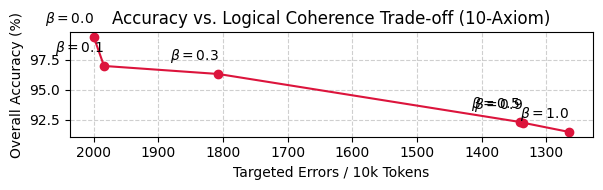

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from output_10.txt
# (Errors/10k, Accuracy)
data = {
    # Baseline from B=0.0 run
    0.0: (2000.07, 99.38),
    # MLNN from B=0.1 run
    0.1: (1984.24, 96.98),
    # MLNN from B=0.3 run
    0.3: (1807.10, 96.31),
    # MLNN from B=0.5 run
    0.5: (1340.45, 92.32),
    # MLNN from B=0.9 run
    0.9: (1336.08, 92.26),
    # MLNN from B=1.0 run
    1.0: (1264.26, 91.49)
}

betas = sorted(data.keys())
errors = [data[b][0] for b in betas]
accuracy = [data[b][1] for b in betas]

fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(errors, accuracy, marker='o', linestyle='-', color='crimson')

ax.set_xlabel('Targeted Errors / 10k Tokens')
ax.set_ylabel('Overall Accuracy (%)')
ax.set_title('Accuracy vs. Logical Coherence Trade-off (10-Axiom)')

# Annotate points
for b in betas:
    ax.annotate(f'$\\beta={b}$', (data[b][0], data[b][1]),
                textcoords="offset points",
                xytext=(0,10),
                ha='right')

# Invert x-axis to show improvement to the left
ax.invert_xaxis()
ax.grid(True, linestyle='--', alpha=0.6)
fig.tight_layout()
fig.savefig(f'{SAVE_FOLDER}/pos_tradeoff.pdf')
plt.show()

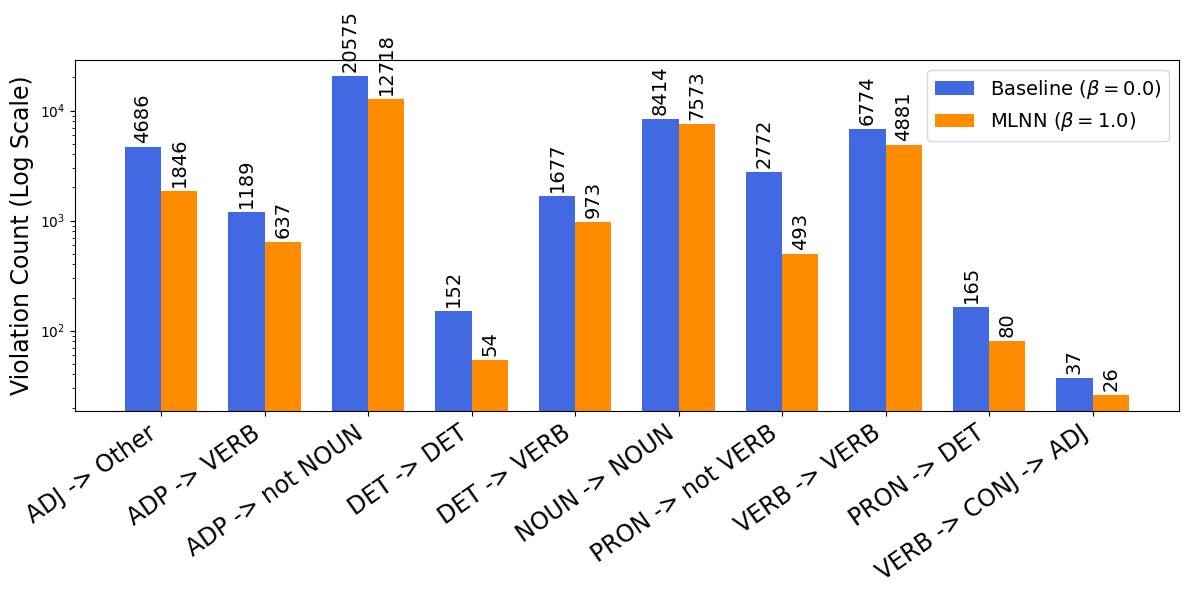

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from output_10.txt
# Baseline (from B=0.0 run)
baseline_errors = {
    'ADJ -> Other': 4686,
    'ADP -> VERB': 1189,
    'ADP -> not NOUN': 20575,
    'DET -> DET': 152,
    'DET -> VERB': 1677,
    'NOUN -> NOUN': 8414,
    'PRON -> not VERB': 2772,
    'VERB -> VERB': 6774,
    'PRON -> DET': 165,
    'VERB -> CONJ -> ADJ': 37,
}

# MLNN (B=1.0 run)
mlnn_errors = {
    'ADJ -> Other': 1846,
    'ADP -> VERB': 637,
    'ADP -> not NOUN': 12718,
    'DET -> DET': 54,
    'DET -> VERB': 973,
    'NOUN -> NOUN': 7573,
    'PRON -> not VERB': 493,
    'VERB -> VERB': 4881,
    'PRON -> DET': 80,
    'VERB -> CONJ -> ADJ': 26,
}

labels = list(baseline_errors.keys())
baseline_values = [baseline_errors[k] for k in labels]
mlnn_values = [mlnn_errors[k] for k in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, baseline_values, width,
                label='Baseline ($\\beta=0.0$)', color='royalblue')
rects2 = ax.bar(x + width/2, mlnn_values, width,
                label='MLNN ($\\beta=1.0$)', color='darkorange')

ax.set_ylabel('Violation Count (Log Scale)',fontsize = 17)
# ax.set_title('Per-Axiom Violation Counts (10-Axiom Experiment)')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=35, ha='right', fontsize = 17)
ax.set_yscale('log')
ax.legend(fontsize = 14)

ax.bar_label(rects1, padding=3, fmt='%d', rotation=90, fontsize=14)
ax.bar_label(rects2, padding=3, fmt='%d', rotation=90, fontsize=14)
fig.savefig(f'{SAVE_FOLDER}/axiom_reduction.pdf')
fig.tight_layout()
fig.savefig(f'axiom_reduction.pdf')
plt.show()